In [113]:
#importing necessary libraries
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="whitegrid")
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf
yf.pdr_override()

We define a function that makes it easy to find cointegrated security pairs. We perform Augmented Dickey Fuller test on each pair and select those who have have p value less than 0.05.  

In [114]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

We are looking through a set of tech companies in USA to see if any of them are cointegrated. We'll start by defining the list of securities we want to look through. Then we'll get the pricing data for each security from the year 2015-2020. 

We have formulated an economic hypothesis that there is some sort of link between a subset of securities within the tech sector and we want to test whether there are any cointegrated pairs. We can also include an index which tracks the overall market. 
This incurs significantly less multiple comparisons bias than searching through hundreds of securities and slightly more than forming a hypothesis for an individual test.

Note:- We were going to perform this on Indian stocks but experienced errors in the available data. 

In [115]:
start = datetime.datetime(2015, 1, 1)
end = datetime.datetime(2020, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

df = pdr.get_data_yahoo(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  11 of 11 completed


,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2019-12-24,71.067497,329.640015,46.540001,36.209999,20.590000,134.979996,24.290001,157.380005,53.439999,88.769997,321.230011
2019-12-26,72.477501,331.200012,46.630001,36.250000,20.690001,134.910004,24.490000,158.669998,53.570000,88.400002,322.940002
2019-12-27,72.449997,330.790009,46.180000,36.070000,20.530001,135.270004,24.410000,158.960007,53.459999,88.800003,322.859985
2019-12-30,72.879997,328.339996,45.520000,35.799999,20.490000,132.809998,24.500000,157.589996,52.700001,88.430000,321.079987
2019-12-31,73.412498,329.809998,45.860001,36.110001,20.549999,134.039993,24.629999,157.699997,52.980000,88.230003,321.859985


In [116]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
print(pairs)

[('JNPR', 'MSFT'), ('JNPR', 'ORCL'), ('JNPR', 'QCOM'), ('ORCL', 'SPY')]


We have 4 pairs of cointegrated stocks as given above.

We will continue further with the ('ORCL', 'SPY') pair. Here, ORCL is the ticker for Oracle Corporation and SPY is the ticker for SPDR S&P 500 ETF Trust which tracks the 500 biggest public companies in USA. 

In [117]:
S1 = df['ORCL']
S2 = df['SPY']

score, pvalue, _ = coint(S1, S2)
pvalue

0.023401544863918076

The p-value for the pair ('ORCL', 'SPY') is 0.023 which is lesser than 0.05. 

Next, we are going to calculate the spread between the two stocks. 
The spread is given by, spread = S2 - b * S1 where S1 is the stock 1 and S2 is stock 2, and b is the correlation coefficient obtained from linear regression. 

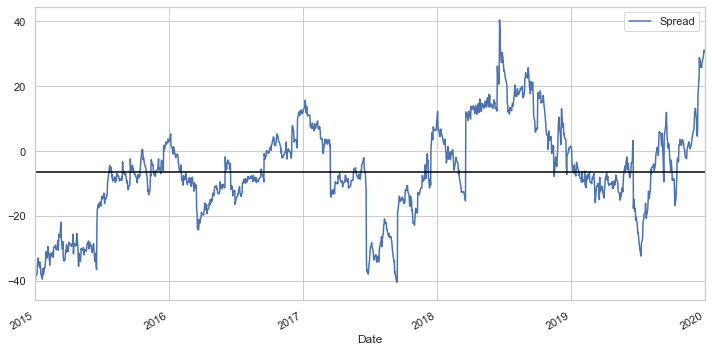

In [118]:
S1 = sm.add_constant(S1)
results = sm.OLS(S2, S1).fit()
S1 = S1['ORCL']
b = results.params['ORCL']

spread = S2 - b * S1
spread.plot(figsize=(12,6))
plt.axhline(spread.mean(), color='black')
plt.xlim('2015-01-01', '2020-01-01')
plt.legend(['Spread']);

We can also calculate the ratio between the stocks, ratio = S1/S2, where S1 is the stock 1 and S2 is stock 2. 

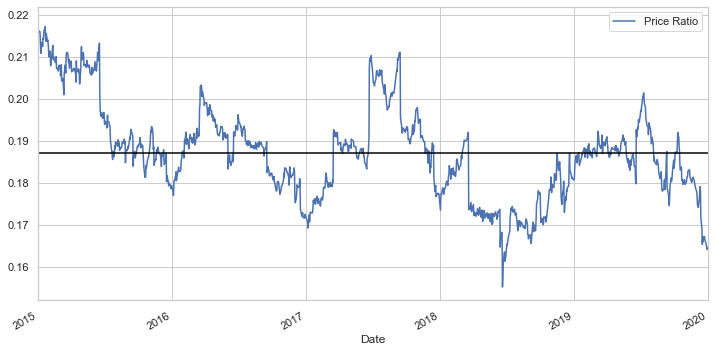

In [119]:
ratio = S1/S2
ratio.plot(figsize=(12,6))
plt.axhline(ratio.mean(), color='black')
plt.xlim('2015-01-01', '2020-01-01')
plt.legend(['Price Ratio']);

We can use the spread approach or the ratio approach, we can see that our plot pair ORCL/SPY tends to move around the mean. We now need to standardize this ratio because the absolute ratio might not be the most ideal way of analyzing this trend. For this, we need to use z-scores.

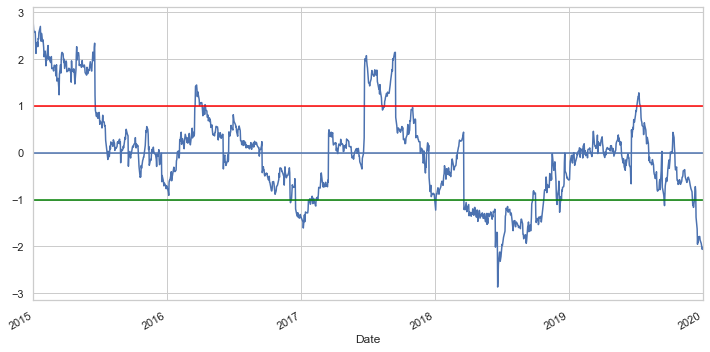

In [120]:
def zscore(series):
    return (series - series.mean()) / np.std(series)


zscore(ratio).plot(figsize=(12,6))
plt.axhline(zscore(ratio).mean())
plt.axhline(1.0, color='red')
plt.axhline(-1.0, color='green')
plt.xlim('2015-01-01', '2020-01-01')
plt.show()

By setting two other lines placed at the z-score of 1 and -1, we can clearly see that for the most part, any big divergences from the mean eventually converges back. This is exactly what we want for a pairs trading strategy.

### Trading Signals

When conducting any type of trading strategy, it's always important to clearly define and delineate at what point you will actually do a trade. As in, what is the best indicator that I need to buy or sell a particular stock? 

#### Setup rules

We're going to use the ratio time series that we've created to see if it tells us whether to buy or sell a particular moment in time. We'll start off by creating a prediction variable $Y$. If the ratio is positive, it will signal a "buy," otherwise, it will signal a sell. The prediction model is as follows:

$$Y_{t} = sign(Ratio_{t+1}-Ratio_{t}) $$

What's great about pair trading signals is that we don't need to know absolutes about where the prices will go, all we need to know is where it's heading: up or down.

#### Train Test Split

When training and testing a model, it's common to have splits of 70/30 or 80/20. We only used a time series of 252 points (which is the amount of trading days in a year). Before training and splitting the data, we will add more data points in each time series.

In [121]:
ratios = df['ORCL'] / df['SPY'] 
print(len(ratios) * .70 ) 

881.3


In [122]:
train = ratios[:881]
test = ratios[881:]

#### Feature Engineering

We need to find out what features are actually important in determining the direction of the ratio moves. Knowing that the ratios always eventually revert back to the mean, maybe the moving averages and metrics related to the mean will be important.

Let's try using these features:

* 60 day Moving Average of Ratio
* 5 day Moving Average of Ratio
* 60 day Standard Deviation
* z score

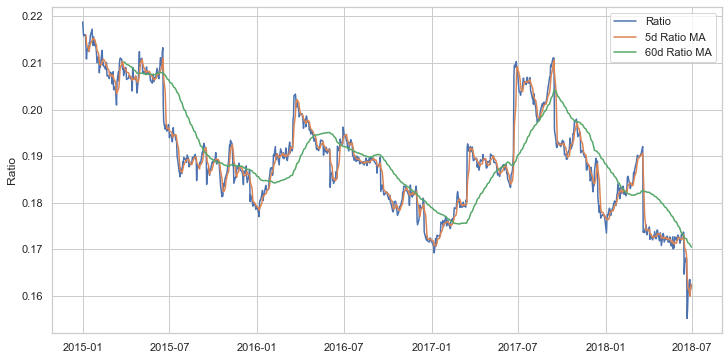

In [123]:
ratios_mavg5 = train.rolling(window=5, center=False).mean()
ratios_mavg60 = train.rolling(window=60, center=False).mean()
std_60 = train.rolling(window=60, center=False).std()
zscore_60_5 = (ratios_mavg5 - ratios_mavg60)/std_60
plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values)
plt.plot(ratios_mavg5.index, ratios_mavg5.values)
plt.plot(ratios_mavg60.index, ratios_mavg60.values)
plt.legend(['Ratio', '5d Ratio MA', '60d Ratio MA'])

plt.ylabel('Ratio')
plt.show()

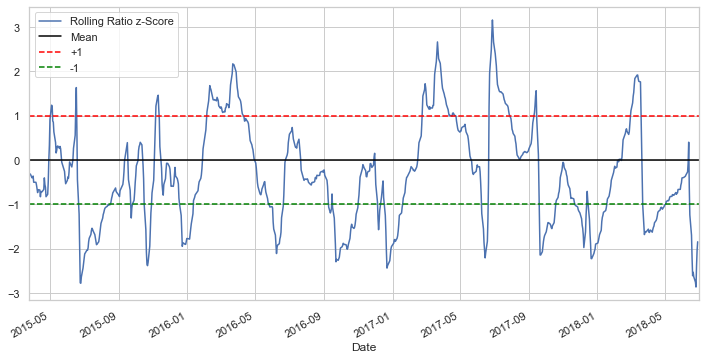

In [124]:
plt.figure(figsize=(12,6))
zscore_60_5.plot()
plt.xlim('2015-03-25', '2018-07-01')
plt.axhline(0, color='black')
plt.axhline(1.0, color='red', linestyle='--')
plt.axhline(-1.0, color='green', linestyle='--')
plt.legend(['Rolling Ratio z-Score', 'Mean', '+1', '-1'])
plt.show()

Here, we are using short term averages and then we have plotted the deviations. 

#### Creating a Model

A standard normal distribution has a mean of 0 and a standard deviation 1. Looking at the plot, it's pretty clear that if the time series moves 1 standard deviation beyond the mean, it tends to revert back towards the mean. Using these models, we can create the following trading signals:

* Buy(1) whenever the z-score is below -1, meaning we expect the ratio to increase.
* Sell(-1) whenever the z-score is above 1, meaning we expect the ratio to decrease.

#### Training Optimizing

We can use our model on actual data

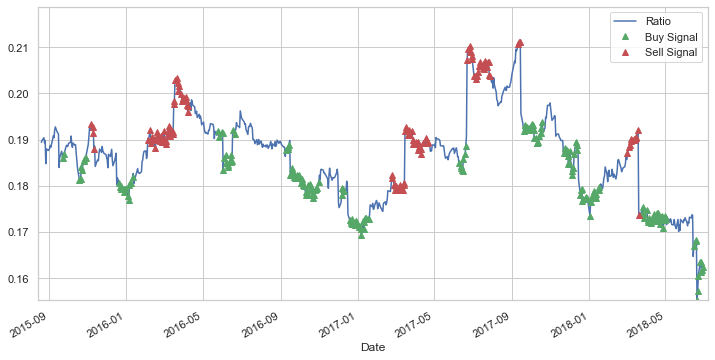

In [125]:
plt.figure(figsize=(12,6))

train[160:].plot()
buy = train.copy()
sell = train.copy()
buy[zscore_60_5>-1] = 0
sell[zscore_60_5<1] = 0
buy[160:].plot(color='g', linestyle='None', marker='^')
sell[160:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, ratios.min(), ratios.max()))
plt.xlim('2015-08-15','2018-07-07')
plt.legend(['Ratio', 'Buy Signal', 'Sell Signal'])
plt.show()

Here, buy means buy the stock S1 in x amount and sell the stock S2 in x*ratio amount. Thus, in theory the money we need is essentially zero.  

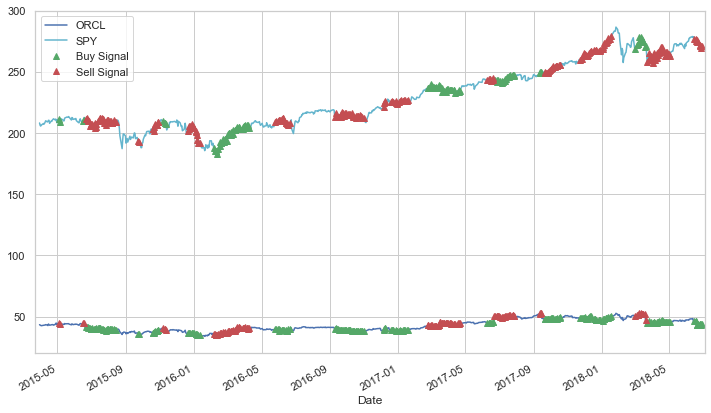

In [126]:
plt.figure(figsize=(12,7))
S1 = df['ORCL'].iloc[:881]
S2 = df['SPY'].iloc[:881]

S1[60:].plot(color='b')
S2[60:].plot(color='c')
buyR = 0*S1.copy()
sellR = 0*S1.copy()

# When you buy the ratio, you buy stock S1 and sell S2
buyR[buy!=0] = S1[buy!=0]
sellR[buy!=0] = S2[buy!=0]

# When you sell the ratio, you sell stock S1 and buy S2
buyR[sell!=0] = S2[sell!=0]
sellR[sell!=0] = S1[sell!=0]

buyR[60:].plot(color='g', linestyle='None', marker='^')
sellR[60:].plot(color='r', linestyle='None', marker='^')
x1, x2, y1, y2 = plt.axis()
plt.axis((x1, x2, min(S1.min(), S2.min()), max(S1.max(), S2.max())))
plt.ylim(20, 300)
plt.xlim('2015-03-22', '2018-07-04')

plt.legend(['ORCL', 'SPY', 'Buy Signal', 'Sell Signal'])
plt.show()

Now we can clearly see when we should buy or sell on the respective stocks.

Now, we will calculate the total profits made using this strategy. 

In [127]:
# Trade using a simple strategy
def trade(S1, S2, window1, window2):
    
    # If window length is 0, algorithm doesn't make sense, so exit
    if (window1 == 0) or (window2 == 0):
        return 0
    
    # Compute rolling mean and rolling standard deviation
    ratios = S1/S2
    ma1 = ratios.rolling(window=window1,
                               center=False).mean()
    ma2 = ratios.rolling(window=window2,
                               center=False).mean()
    std = ratios.rolling(window=window2,
                        center=False).std()
    zscore = (ma1 - ma2)/std
    
    # Simulate trading
    # Start with no money and no positions
    money = 0
    countS1 = 0
    countS2 = 0
    for i in range(len(ratios)):
        # Sell short if the z-score is > 1
        if zscore[i] < -1:
            money += S1[i] - S2[i] * ratios[i]
            countS1 -= 1
            countS2 += ratios[i]
            #print('Selling Ratio %s %s %s %s'%(money, ratios[i], countS1,countS2))
        # Buy long if the z-score is < -1
        elif zscore[i] > 1:
            money -= S1[i] - S2[i] * ratios[i]
            countS1 += 1
            countS2 -= ratios[i]
            #print('Buying Ratio %s %s %s %s'%(money,ratios[i], countS1,countS2))
        # Clear positions if the z-score between -.5 and .5
        elif abs(zscore[i]) < 0.75:
            money += S1[i] * countS1 + S2[i] * countS2
            countS1 = 0
            countS2 = 0
            #print('Exit pos %s %s %s %s'%(money,ratios[i], countS1,countS2))
            
            
    return money

In [128]:
trade(df['ORCL'].iloc[881:], df['SPY'].iloc[881:], 60, 5)

220.08601023527015

Thus, our profit is 220.08 USD in this trading startegy applied to the ('ORCL', 'SPY') pair in 378 trading days. 

There are several things that can be improved upon in the startegy and its implementation such as:- 

#### 1. Using more securities and more varied time ranges

We can use large number of stocks to identify better cointegrated stocks. We can also increase the timeframe from 5 years so that we identify if there is mean reversion in long term and ignore the stock market volatility. 

#### 2. Using target and stoploss while trading
We can use this to minimize our risks and cut down on our losses to increase net profits. 

